# Strating with a Simple Example: Digits Data from sklearn
Let's start our adventure into convolutional networks with a simple example of the digits dataset. This was not always such a simple example, but modern day computing power and open source tools has made it a significantly more tractable problem. 

In [1]:

from sklearn import datasets as ds
import pandas as pd
import numpy as np
import os, os.path
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.pyplot as plt
import colorsys
import copy
from PIL import Image

from sklearn.decomposition import KernelPCA
import zipfile

import skimage
from skimage import io

from skimage.transform import resize
from random import shuffle
import seaborn as sns

from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
import numpy as np

import re


# define X and y here.
import glob2
from PIL import Image
import matplotlib.image as mpimg




In [2]:
image_data = []
image_labels = []

directory = "./train"
os.walk(directory)
folder_names = [x[0] for x in os.walk(directory)]
del folder_names[0]
print(folder_names)
categories = {category.replace('./train\\', '') for category in folder_names}
print(categories)

['./train/ALB', './train/BET', './train/DOL', './train/LAG', './train/NoF', './train/OTHER', './train/SHARK', './train/YFT']
{'./train/NoF', './train/SHARK', './train/LAG', './train/OTHER', './train/YFT', './train/DOL', './train/ALB', './train/BET'}


In [5]:
import os
import shutil
max = 50
i = 0
flag = False
labels = []
for sub in os.listdir('./train'):
    if(sub == '.DS_Store'):
        continue
    for file in os.listdir('./train/'+sub):
        labels.append(sub);
        shutil.copy2('./train/'+ sub + '/'+ file,'./train2')
        i += 1
        if(i == max):
            flag = True
            break
    if(flag == True):
        i = 0
fish_image_files = glob2.glob('train2/*.jpg')
print(len(fish_image_files))

398


In [4]:
#%%time
#fish_image_files = glob2.glob('train/**/*.jpg')
size = 300, 300

igs = np.array([skimage.transform.resize(skimage.io.imread(fname, as_grey=True, plugin=None, flatten=None),(300,300))
                                         for fname in fish_image_files])

In [6]:
print(len(fish_image_files))

398


In [8]:
image_labels = []
for fname in fish_image_files:
    image_labels.append(re.sub('/img.*', '', fname.replace('train2/', '')))

398


## Dimension Reduction

In [9]:
train_data = igs.astype('float32')
train_data = train_data / 255
igs_pca = train_data.reshape(igs.shape[0], (train_data.shape[1]*train_data.shape[2]))
igs_pca.shape
print(igs.shape)
print(igs_pca.shape)

(398, 300, 300)
(398, 90000)


In [20]:
# lets do some PCA of the features and go from 1850 features to 20 features
from sklearn.decomposition import PCA

n_components = 173
print ("Extracting the top %d eigenfishes from %d fishes" % (
    n_components, igs_pca.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(igs_pca)
eigenfishes = pca.components_.reshape((n_components, train_data.shape[1]*train_data.shape[2]))

Extracting the top 173 eigenfishes from 398 fishes
CPU times: user 16.4 s, sys: 936 ms, total: 17.3 s
Wall time: 9.62 s


In [25]:
#train_data = igs.astype('float32')
#train_data = train_data / 255
#igs_pca = train_data.reshape(igs.shape[0], (train_data.shape[1]*train_data.shape[2]))
X = igs_pca
y = np.asarray(labels)

print(X.shape)
print(y.shape)

(398, 90000)
(400,)


In [22]:
# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Split X_train again to create validation data
#X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2)

X_train.shape

ValueError: Found input variables with inconsistent numbers of samples: [398, 400]

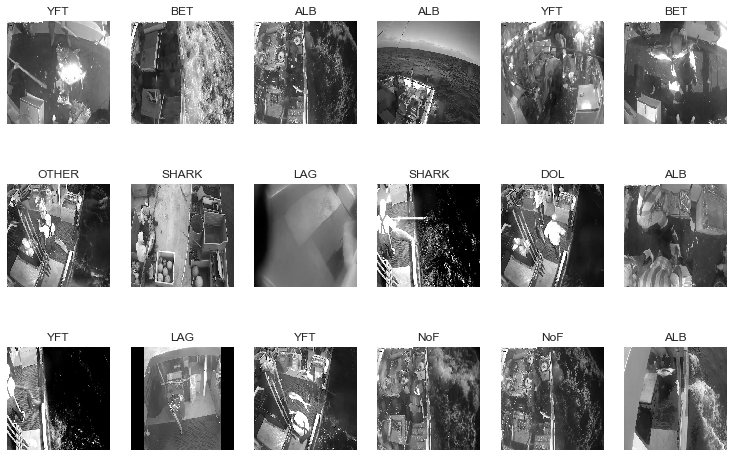

In [54]:
# What do these images look like?
from matplotlib import pyplot as plt
%matplotlib inline

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, 8, 8) # defaults to showing a 3 by 6 subset of the images

In [55]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

keras.__version__

'2.0.3'

In [56]:
NUM_CLASSES = 8

print(X_train.shape)
print(X_test.shape)

(320, 300, 300)
(80, 300, 300)


In [57]:
#vectorize images
X_train = X_train.reshape(320, 90000)
X_test = X_test.reshape(80, 90000)

In [58]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)
list(le.classes_)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [59]:
print(le.classes_)

['ALB' 'BET' 'DOL' 'LAG' 'NoF' 'OTHER' 'SHARK' 'YFT']


# Cost Matrix and Custom Scorer

In [60]:
cost_matrix = np.matrix([[0,1,1,1,1,1,1,1],
[1.5,0,1.5,1.5,1.5,1.5,1.5,1.5],
[.5,0,.5,.5,.5,.5,.5,.5],
[1,1,1,0,1,1,1,1],
[1,1,1,1,0,1,1,1],
[1,1,1,1,1,0,1,1],
[2,2,2,2,2,2,0,2],
[1.25,1.25,1.25,1.25,1.25,1.25,1.25,0]])

def get_confusion_costTot(confusion_matrix, cost_matrix):
    score = np.sum(confusion_matrix*cost_matrix)
    return score

In [17]:
%%time

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Dense(input_dim=X_train.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=1, 
        shuffle=True, verbose=0)

CPU times: user 2.23 s, sys: 551 ms, total: 2.78 s
Wall time: 2.79 s


In [18]:
#%%time

# make a CNN with conv layer and max pooling
cnn = Sequential()
cnn.add(Reshape((1,300,300), input_shape=(1,90000)))
cnn.add(Conv2D(filters=16, kernel_size= (2, 2), padding='same', input_shape=(1,300,300)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
# add one layer on flattened output
cnn.add(Flatten())
cnn.add(Dense(NUM_CLASSES))
cnn.add(Activation('softmax'))

# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=1, 
        shuffle=True, verbose=0)

In [64]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        #acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        acc_cnn = get_confusion_costTot(cm, cost_matrix)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        #acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        acc_mlp = get_confusion_costTot(cm, cost_matrix)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

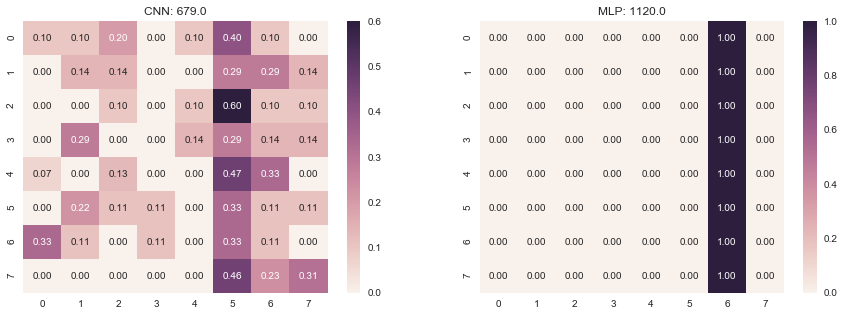

In [65]:
compare_mlp_cnn(cnn,mlp,X_test,y_test)

CPU times: user 4.52 s, sys: 306 ms, total: 4.83 s
Wall time: 2.61 s


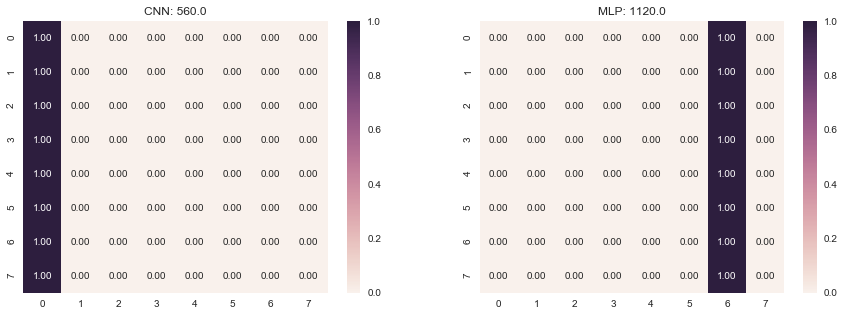

In [66]:
%%time

# changes: 
#    1. increased kernel size
cnn2 = Sequential()
cnn2.add(Reshape((1,300,300), input_shape=(1,90000)))
cnn2.add(Conv2D(filters=16, kernel_size= (3, 3), padding='same', input_shape=(1,300,300)))
cnn2.add(Activation('relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
# add one layer on flattened output
cnn2.add(Flatten())
cnn2.add(Dense(NUM_CLASSES))
cnn2.add(Activation('softmax'))

# Let's train the model 
cnn2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn2.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=1, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn2,mlp,X_test,y_test)

CPU times: user 6.59 s, sys: 484 ms, total: 7.07 s
Wall time: 3.33 s


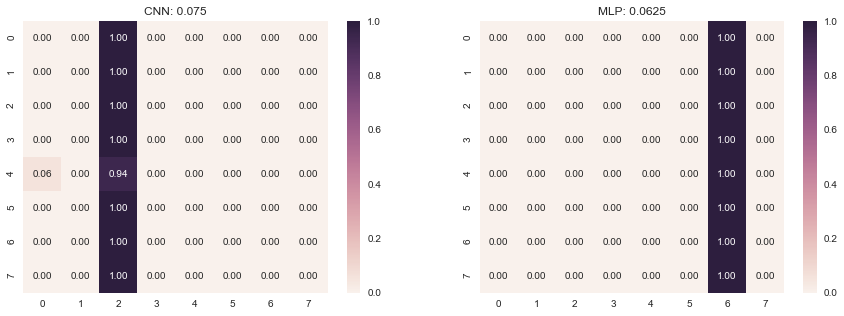

In [22]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer 
cnn3 = Sequential()
cnn3.add(Reshape((1,300,300), input_shape=(1,90000)))

num_filt_layers = [32, 32]
for num_filters in num_filt_layers:
    cnn3.add(Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same'))
    cnn3.add(Activation('relu'))
    cnn3.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    

# add one layer on flattened output
cnn3.add(Flatten())
cnn3.add(Dense(NUM_CLASSES))
cnn3.add(Activation('softmax'))

# Let's train the model 
cnn3.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn3.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=1, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn3,mlp,X_test,y_test)

CPU times: user 1min 26s, sys: 10.2 s, total: 1min 37s
Wall time: 33 s


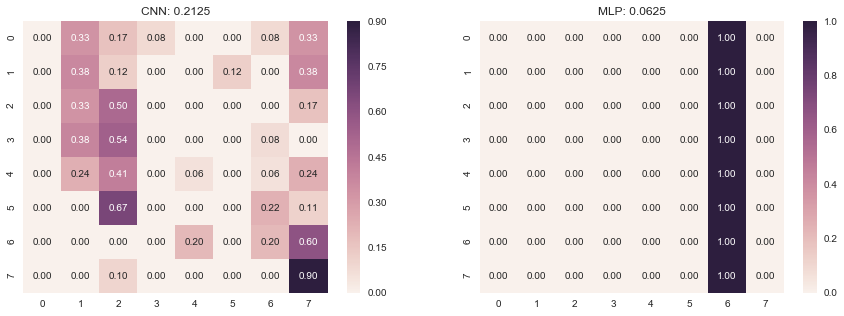

In [23]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer with increasing num filters
#    3. add more layers once flattened
cnn4 = Sequential()
cnn4.add(Reshape((1,300,300), input_shape=(1,90000)))

num_filt_layers = [24, 48]
for num_filters in num_filt_layers:
    cnn4.add(Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    

# add one layer on flattened output
cnn4.add(Flatten())
cnn4.add(Dense(100))
cnn4.add(Activation('relu'))
cnn4.add(Dense(NUM_CLASSES))
cnn4.add(Activation('softmax'))

# Let's train the model 
cnn4.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn4.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=64, epochs=20, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn4,mlp,X_test,y_test)

# Exceptional Work 

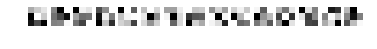

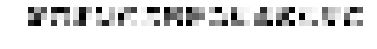

In [45]:
max_plots = 15
for layer in cnn4.layers:
    if type(layer) == keras.layers.convolutional.Conv2D:
        weights = layer.get_weights()[0]
        for i in range(min(weights.shape[-1], max_plots)):
            plt.subplot(1, min(weights.shape[-1], max_plots), i+1)
            plt.imshow(weights[:,:,0,i])
            plt.axis('off')
        plt.show()